In [5]:
# Data Processing
import pandas as pd
import numpy as np
import re
from numpy import mean, std

# Data visualization
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Creating the modeling dataset
from sklearn.datasets import make_classification

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Model and performance
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score, 
                                     KFold, 
                                     RepeatedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             ConfusionMatrixDisplay,
                             matthews_corrcoef)
from sklearn.metrics import classification_report
from datetime import datetime
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

# Treating data imbalance
!pip install -U imbalanced-learn

# checking memory space usage
import tracemalloc

# normality check
import math
from scipy.stats import shapiro #shapiro-wilk test

import warnings
warnings.filterwarnings("ignore")

!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

## Loading and prepraing dataset

In [6]:
# Loading dataset
df1 = pd.read_csv('adult_data.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df2 = pd.read_csv('adult_test.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df = pd.concat([df1, df2], ignore_index = True)
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation', 'relationship','race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
                'country', 'income']
df.columns = column_names

# Changing the target variable class from categorical to numerical
df_mod = df.copy()
df_mod['income'] = df_mod['income'].str.replace('<=50K.', '<=50K',regex=False)
df_mod['income'] = df_mod['income'].str.replace('>50K.', '>50K', regex=False)
income_map={' <=50K':0,' >50K':1}
df_mod['income']=df_mod['income'].map(income_map).astype(int)
df_mod.income.value_counts()

# Aggregating class levels of 'Education' category
df_mod['education'] = df_mod['education'].str.replace('11th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('9th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('7th-8th','Junior-High', regex = True)
df_mod['education'] = df_mod['education'].str.replace('5th-6th', 'Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('10th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('1st-4th','Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Preschool','Pre-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('12th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Bachelors','Bachelors', regex = True)
df_mod['education'] = df_mod['education'].str.replace('HS-grad','HS-grad', regex = True)
df_mod['education'] = df_mod['education'].replace(['Masters', 'Prof-school'],'Masters', regex = True)
df_mod['education'] = df_mod['education'].replace(['Some-college','Assoc-acdm', 'Assoc-voc'],'College', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Doctorate','Doctorate', regex = True)
df_mod['education'].unique()

# Dropping Duplicates
df_mod = df_mod.drop_duplicates()

# Removing missing values
x = df_mod.copy()
df_m1 = x.dropna()

# Data Encoding
df_m1_num = df_m1.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country'], axis=1)
df_encoded1 = pd.get_dummies(df_m1[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country']],)
df_encoded1 = pd.concat([df_encoded1, df_m1_num], axis=1)
df_encoded1

# Train-test split for df_encoded1 dataset
X = df_encoded1.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df_encoded1['income'] # Target variable
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)
print("The number of records in the training set is", X_train1.shape[0])
print("The number of records in the test set is", X_test1.shape[0])

The number of records in the training set is 31622
The number of records in the test set is 13553


## XGBoost: Baseline model

Train accuracy 0.8980140408576308
Test accuracy 0.8658599572050468
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     10206
           1       0.78      0.64      0.70      3347

    accuracy                           0.87     13553
   macro avg       0.83      0.79      0.81     13553
weighted avg       0.86      0.87      0.86     13553



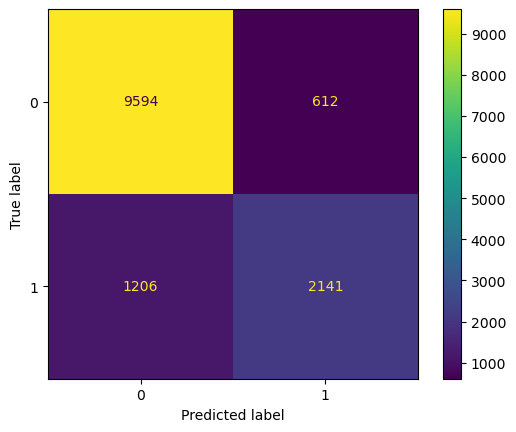

MCC score: 0.62


In [22]:
# XGBoost on df_encoded1 data

cf = XGBClassifier()
X_train = X_train1
X_test = X_test1
y_train = y_train1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

## XGBoost: Class Imbalance treated data and tuning hyper parameters

Important hyper-parameters that we will fine tune are :
* Max_depth
* Subsample
* colsample_bylevel
* colsample_bytree
* min_child_weight
* n_estimators
* learning_rate

### Random oversampled data

Train accuracy 0.8888374637101863
Test accuracy 0.8365675496200103
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     10206
           1       0.63      0.83      0.72      3347

    accuracy                           0.84     13553
   macro avg       0.78      0.83      0.80     13553
weighted avg       0.86      0.84      0.84     13553



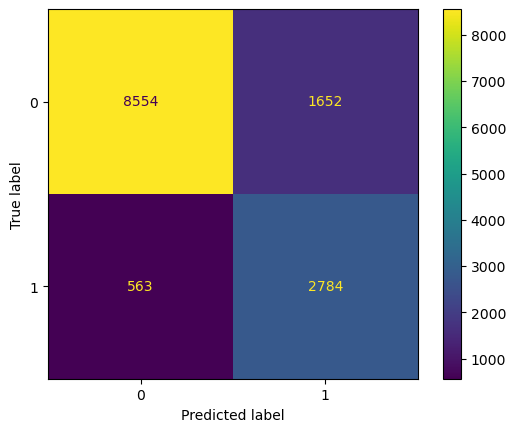

MCC score: 0.62


In [9]:
# Random Oversampling
ros = RandomOverSampler()
X_train_ros1, y_train_ros1 = ros.fit_resample(X_train1, y_train1)


# Running model
cf = XGBClassifier()
X_train = X_train_ros1
X_test = X_test1
y_train = y_train_ros1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.8793284806664703
Test accuracy 0.8348705083745296
              precision    recall  f1-score   support

           0       0.94      0.84      0.88     10206
           1       0.62      0.83      0.71      3347

    accuracy                           0.83     13553
   macro avg       0.78      0.83      0.80     13553
weighted avg       0.86      0.83      0.84     13553



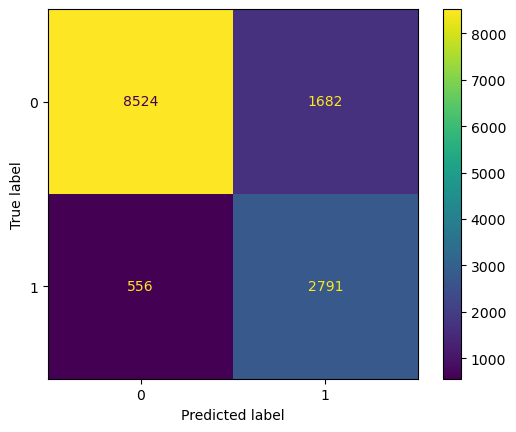

MCC score: 0.61


In [10]:
# Random Oversampling
ros = RandomOverSampler()
X_train_ros1, y_train_ros1 = ros.fit_resample(X_train1, y_train1)


# Running model
cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.2,
                   min_child_weight = 1)
X_train = X_train_ros1
X_test = X_test1
y_train = y_train_ros1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

### SMOTE Oversampled data

Train accuracy 0.9315858122606976
Test accuracy 0.8626134435180403
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     10206
           1       0.75      0.67      0.71      3347

    accuracy                           0.86     13553
   macro avg       0.82      0.80      0.81     13553
weighted avg       0.86      0.86      0.86     13553



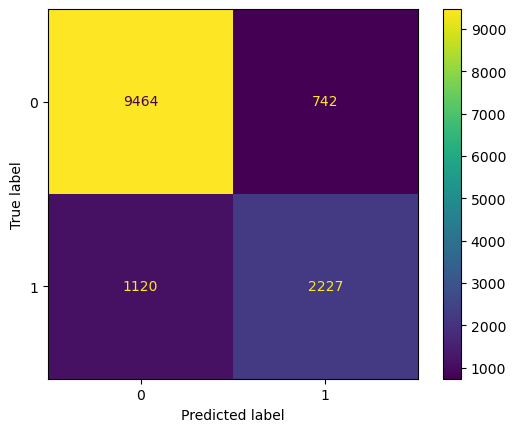

MCC score: 0.62


In [11]:
# SMOTE Oversampling
smote1 = SMOTE()
X_train_smote1, y_train_smote1 = smote1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier()
X_train = X_train_smote1
X_test = X_test1
y_train = y_train_smote1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.927441410358901
Test accuracy 0.8650483287832952
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10206
           1       0.75      0.67      0.71      3347

    accuracy                           0.87     13553
   macro avg       0.82      0.80      0.81     13553
weighted avg       0.86      0.87      0.86     13553



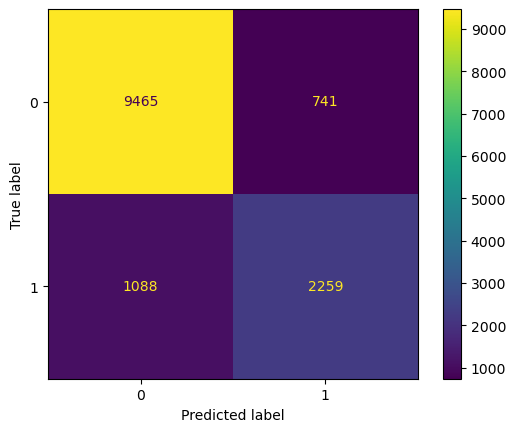

MCC score: 0.63


In [12]:
# SMOTE Oversampling
smote1 = SMOTE()
X_train_smote1, y_train_smote1 = smote1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.3,
                   min_child_weight = 1,
                   colsample_bytree = 0.3)
X_train = X_train_smote1
X_test = X_test1
y_train = y_train_smote1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

### Random Undersampled data

Train accuracy 0.8992361553150859
Test accuracy 0.8276396369807423
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     10206
           1       0.61      0.85      0.71      3347

    accuracy                           0.83     13553
   macro avg       0.78      0.84      0.79     13553
weighted avg       0.86      0.83      0.84     13553



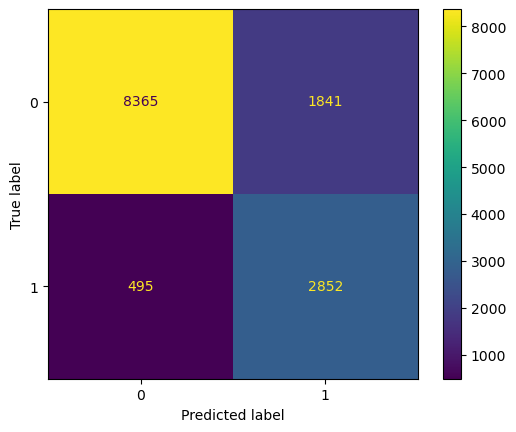

MCC score: 0.61


In [13]:
# Random Undersampling
rus1 = RandomUnderSampler()
X_train_rus1, y_train_rus1 = rus1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier()
X_train = X_train_rus1
X_test = X_test1
y_train = y_train_rus1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.88026734563972
Test accuracy 0.8299269534420424
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10206
           1       0.61      0.85      0.71      3347

    accuracy                           0.83     13553
   macro avg       0.78      0.84      0.80     13553
weighted avg       0.86      0.83      0.84     13553



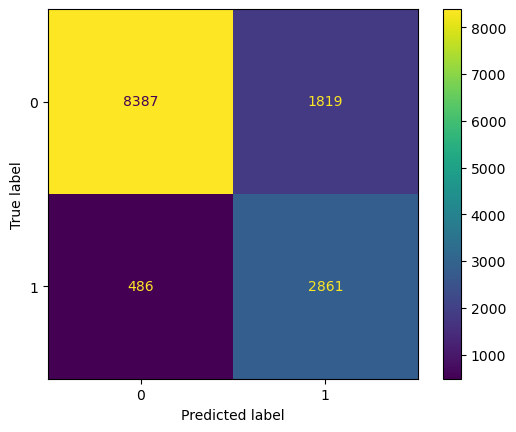

MCC score: 0.61


In [14]:
# Random Undersampling
rus1 = RandomUnderSampler()
X_train_rus1, y_train_rus1 = rus1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.3,
                   min_child_weight = 1,
                   colsample_bytree = 0.3)
X_train = X_train_rus1
X_test = X_test1
y_train = y_train_rus1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

### NearMiss Undersampled data

Train accuracy 0.8916613621896881
Test accuracy 0.8236552792739615
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     10206
           1       0.60      0.85      0.70      3347

    accuracy                           0.82     13553
   macro avg       0.77      0.83      0.79     13553
weighted avg       0.86      0.82      0.83     13553



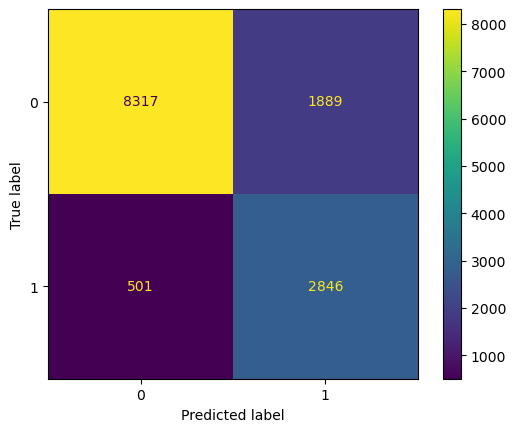

MCC score: 0.60


In [15]:
# NearMiss Undersampling
nearmiss1 = NearMiss(version=3)
X_train_nearmiss1, y_train_nearmiss1 = nearmiss1.fit_resample(X_train1, y_train1)

cf = XGBClassifier()
X_train = X_train_nearmiss1
X_test = X_test1
y_train = y_train_nearmiss1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.8916613621896881
Test accuracy 0.8236552792739615
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     10206
           1       0.60      0.85      0.70      3347

    accuracy                           0.82     13553
   macro avg       0.77      0.83      0.79     13553
weighted avg       0.86      0.82      0.83     13553



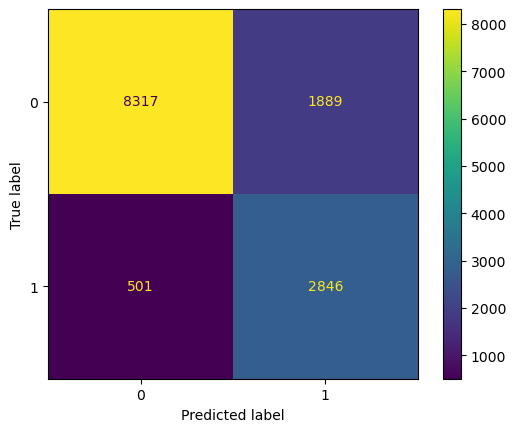

MCC score: 0.60


In [16]:
# NearMiss Undersampling
nearmiss1 = NearMiss(version=3)
X_train_nearmiss1, y_train_nearmiss1 = nearmiss1.fit_resample(X_train1, y_train1)

cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.3,
                   min_child_weight = 1,
                   colsample_bytree = 1)
X_train = X_train_nearmiss1
X_test = X_test1
y_train = y_train_nearmiss1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

## Cross Validation

### Timer setup

In [17]:
# Creating a timer to check time-lapse
# from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Memory usage tracker setup

In [18]:
# memory space usage tracking
# import tracemalloc 
def app():
    lt = []
    for i in range(0, 100000):
        lt.append(i)

### K-Fold Cross Validation

In [21]:
# from sklearn.model_selection import cross_val_score
# K-Fold Cross validation on base dataset

cf = XGBClassifier()

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()

# running cross-val
kfold_score = [cross_val_score (cf, X_train1, y_train1, scoring='accuracy', cv=10)]

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print(kfold_score)
print(np.average(kfold_score))


 Time taken: 0 hours 0 minutes and 46.87 seconds.
memory usage: Current, Peak (46398, 27938734)
[array([0.87164085, 0.86784698, 0.87349779, 0.871284  , 0.86717268,
       0.86717268, 0.85578748, 0.86970272, 0.86780519, 0.87001898])]
0.8681929320737505


### Repeated K-Fold Cross Validation

In [36]:
# Repeated K-Fold on base dataset

cv1 = RepeatedKFold(n_splits=10, n_repeats=5)
cf = cf = XGBClassifier()

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()
 
# running cross-val
repeatK_scores = cross_val_score(cf, X_train1, y_train1, scoring='accuracy', cv=cv1)

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print (repeatK_scores)
print('Accuracy: %.3f (%.3f)' % (mean(repeatK_scores), std(repeatK_scores)))


 Time taken: 0 hours 4 minutes and 26.84 seconds.
memory usage: Current, Peak (68210, 28191165)
[0.86595005 0.86816314 0.87919039 0.86495889 0.87381404 0.871284
 0.8570525  0.86622391 0.86021505 0.87033523 0.86563389 0.86468543
 0.86780519 0.87760911 0.86590765 0.87476281 0.86306135 0.87602783
 0.86590765 0.86685642 0.86784698 0.87701549 0.86748893 0.86748893
 0.86464263 0.86337761 0.8684377  0.87096774 0.88013915 0.87001898
 0.86658236 0.87733165 0.8684377  0.86432638 0.86685642 0.8769766
 0.86907021 0.86211259 0.86116382 0.86780519 0.87575087 0.86500158
 0.86622391 0.86622391 0.87855787 0.87381404 0.86369386 0.86622391
 0.87001898 0.87001898]
Accuracy: 0.869 (0.005)


### Checking the distribution of repeated K-Fold scores

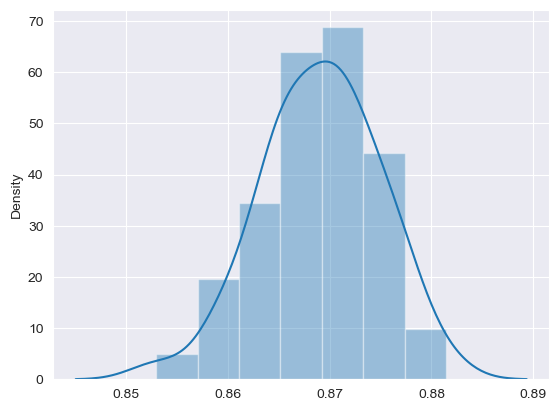

In [25]:
sns.set_style('darkgrid')
sns.distplot(repeatK_scores);

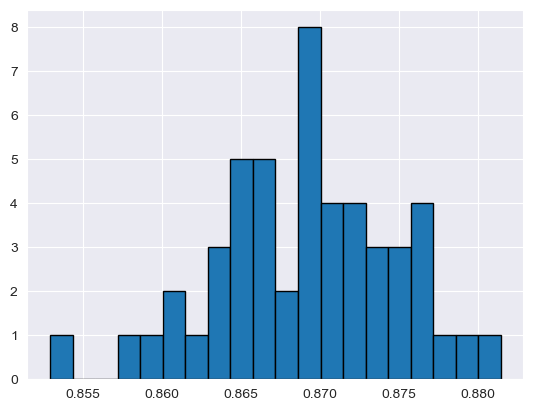

In [26]:
plt.hist(repeatK_scores, edgecolor='black', bins=20);

### Normality check through Shapiro-Wilk Test

In [27]:
# normality check for the repeatK_scores

shapiro(repeatK_scores)

ShapiroResult(statistic=0.9899678826332092, pvalue=0.9454233646392822)

From the output, we can see that p-value is greater than 0.05 which means that we have sufficient evidence to accept the null hypothesis which is the data is normally distributed

## Variance check

In [32]:
xgbscore = repeatK_scores.T
xgbscore

array([0.87543471, 0.87290547, 0.85294118, 0.871284  , 0.86685642,
       0.87666034, 0.87160025, 0.86590765, 0.86590765, 0.86780519,
       0.87132469, 0.86436927, 0.86875395, 0.87318153, 0.87001898,
       0.87887413, 0.8769766 , 0.87602783, 0.85863378, 0.86021505,
       0.88144167, 0.86531774, 0.86875395, 0.87191651, 0.86084756,
       0.86495889, 0.86748893, 0.8741303 , 0.871284  , 0.86527514,
       0.86974391, 0.86373696, 0.86464263, 0.86369386, 0.86875395,
       0.87729285, 0.87160025, 0.87444655, 0.86907021, 0.87444655,
       0.86974391, 0.87701549, 0.85926629, 0.86242884, 0.86590765,
       0.86401012, 0.86654016, 0.87096774, 0.87286528, 0.87001898])

In [33]:
df = pd.read_csv('Repeated K-Fold Cross Validation Scores.csv')
df.head()

,RF
0,0.853936
1,0.854885
2,0.841240
3,0.853574
4,0.860848


In [34]:
df['XGB'] = xgbscore
df.head()

,RF,XGB
0,0.853936,0.875435
1,0.854885,0.872905
2,0.841240,0.852941
3,0.853574,0.871284
4,0.860848,0.866856


In [35]:
df.to_csv('Repeated K-Fold Cross Validation Scores.csv', index=False)